In [1]:
from importlib import reload
import os
import pandas as pd
import sys
sys.path.append('D:/MicroMator/AnalysisTools')
import AnalysisTools as at
reload(at)
import matplotlib.pyplot as plt
import numpy as np

In [2]:
exp_path = 'L:\\ChetanAditya\\chetan_cs3\\2020-10-8_REC1_hailmary_patternsort\\'
channel = 'EVENT-CFP-DMD'
colors = ['rosybrown', 'indianred', 'red', 'lavender', 'cornflowerblue', 'black']
legend = ['all cells (pos0)', 'random sort 1 (pos1)', 'random sort 2 (pos2)', 'ovals (pos3)', 'donut (pos4)']
pos_list = [0,1,2,3,4]
pos_ids_list = [0,1,2,3,4]

In [3]:
track_csvs, RHOD_infos, save_paths, list_ids_allpos = at.load_csvs(pos_list, pos_ids_list, exp_path, channel=False, SegMatorName='SegMator')
print('done loading of csvs')

for i in pos_ids_list:
    if not i:
        list_ids_allpos[i] = [track_csvs[0].loc[track_csvs[0].frame <= 79].particle.unique().tolist()]
    else:
        list_ids_allpos[i] = np.load(os.path.join(exp_path, "Analysis\\Signal_logs\\pos{}\\cell_ids_79.npy".format(i)), allow_pickle=True)

done loading of csvs


In [4]:
#params
maxframe = 150
framenum = 50
realmaxframe = maxframe-framenum
DMDborder = 75
imageborders = (0, 1024)

clean_track_csvs = []
for df in track_csvs:
    ##SORT unusable frames
    newdf = at.clean_maxframe(df, maxframe)
    #newdf = newdf.loc[newdf.frame < realmaxframe]

    ##SORT blips (cells present less than x frames)
    newdf = at.clean_blips(newdf)

    ##SORT cells not in DMD border
    newdf = at.clean_DMDborder(newdf)

    ##SORT cut cells
    newdf = at.clean_borders(newdf, imageborders, 20)
    
    clean_track_csvs.append(newdf)
    
    
print('cleaned csvs')

cleaned csvs


### calculate cells numbers per frame

In [5]:
cells_per_frame = []
results = []
for index, single_df in enumerate(track_csvs):
    cells_per_frame.append(at.get_n_cells_per_frame(single_df))
    
print('extracted cells numbers per frame')

extracted cells numbers per frame


Growth rate pos 0: 0.0051880536463921835 [1/min]
Growth rate pos 1: 0.0073431137972561405 [1/min]
Growth rate pos 2: 0.006731247882721366 [1/min]
Growth rate pos 3: 0.007383025457963377 [1/min]
Growth rate pos 4: 0.007676496663332632 [1/min]


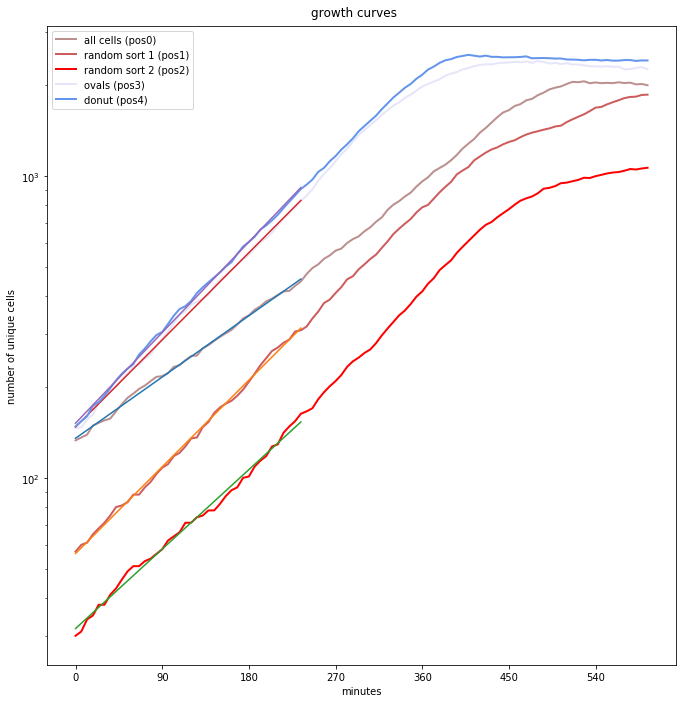

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
fig.tight_layout(pad=3.0)
fig.suptitle('growth curves')

ylab = 'number of unique cells'
xlab = 'minutes'

cutoff = 40
start = 0
times = np.arange(start,cutoff)*6
for i in pos_list:
    ax.set_yscale('log')
    at.simpleline_plot(cells_per_frame[i][:100], ax, '', colors[i], legend[i], ylab, xlab, multiplier=6)
    p = np.polyfit(times, np.log(cells_per_frame[i][start:cutoff]),1)
    ax.plot(times, np.exp(p[1])*np.exp(times*p[0]))
    print('Growth rate pos {0}: {1} [1/min]'.format(i,p[0]))

### Population analysis, this part requires segmator

In [7]:
import segmator.seg_mator as sg
from PIL import Image
import pims
data_path = os.path.join(exp_path, "Analysis\\Binned_images\\pos{}\\binned_img_*_BF.tif")
model_path = os.path.join('C:\\Users\\lifeware\\workspace\\segmator\\models\\unet_yeast_seg_new_v3.hdf5')
mask_path = os.path.join(exp_path, "\\Analysis\\Bitmaps\\pos{}\\")
output_path = os.path.join(exp_path, 'test\\')


track60 = []
for pos in pos_ids_list:
    chimage_path = os.path.join(exp_path ,'Analysis\\Binned_images\\pos{}\\binned_img_80_EVENT-CFP-DMD.tif')
    seg_track = sg.SegMator(data_path.format(pos), mask_path.format(pos), model_path, output_path, input_size=(1024, 1024, 1))
    data_ = clean_track_csvs[pos].loc[clean_track_csvs[pos].frame == 79]
    image = pims.ImageSequence(data_path.format(pos))[79]
    masks = Image.open(os.path.join(exp_path, "Analysis\\Bitmaps\\pos{}\\mask_80_BF.tif".format(pos)), 'r')
    data_ = seg_track.add_contour_to_tracking_single_frame(data_, masks, image)
    track60.append(seg_track.add_fluolevel_to_tracking_single_frame(data_, chimage_path.format(pos), 'EVENT-CFP-DMD'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\lifeware\workspace\segmator\seg_mator.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracking_data['contours'] = contour_list
C:\Users\lifeware\workspace\segmator\seg_mator.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracking_data['area'] = area_list
C:\Users\lifeware\workspace\segmator\seg_mator.py:312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

1078 0
567 533
345 345
628 1081
802 1085


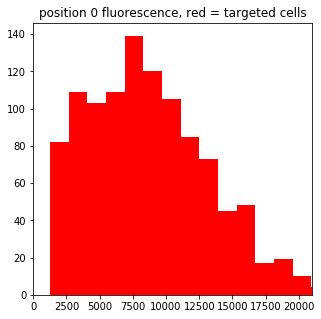

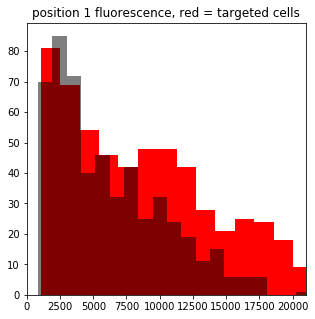

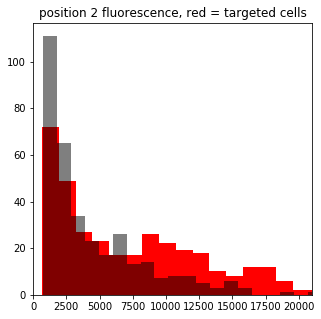

In [8]:
newlist = [] #holds the ids of cells that were targeted for recombination
for j in pos_ids_list:
    if j:
        a = []
        for i in range(1,80):
            if j in (1,2,3,4):
                a+=np.load(os.path.join(exp_path, "Analysis\\Signal_logs\\pos{}\\cell_ids_{}.npy".format(j, i)), allow_pickle=True).tolist()[0]
            else:
                a+=np.load(os.path.join(exp_path, "Analysis\\Signal_logs\\pos{}\\cell_ids_{}.npy".format(j, i)), allow_pickle=True)[0].tolist()
        newlist.append(list(set(a)))
    else:
        newlist.append(track_csvs[0].loc[track_csvs[0].frame <= 79].particle.unique().tolist())

for i in pos_ids_list:
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    cutoff = 10000
    normed = False
    bins = 20
    fluo = track60[i].loc[track60[i].particle.isin(newlist[i])].sort_values('particle')['{} max'.format(channel)][:cutoff]
    off  = track60[i].loc[~track60[i].particle.isin(newlist[i])].sort_values('particle')['{} max'.format(channel)][:cutoff]
    print(len(fluo), len(off))
    ax.hist(fluo, bins=bins, density=normed, color='red')
    ax.set_xlim((0, 21000))
    ax.hist(off, bins=bins, alpha=.5, density=normed, color='black')
    ax.set_title("position "+str(i)+" fluorescence, red = targeted cells")

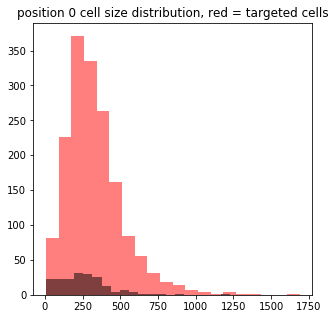

In [9]:
bins = 20
cellnum = 10000
frame = 80
for i in pos_ids_list:
    area = track_csvs[i].loc[(track_csvs[i].particle.isin(newlist[i])) & (track_csvs[i].frame == frame)].sort_values('particle')[:cellnum].area
    narea = track_csvs[i].loc[(~track_csvs[i].particle.isin(newlist[i])) & (track_csvs[i].frame == frame)].sort_values('particle')[:cellnum].area

    fig, ax = plt.subplots(1, 1, figsize=(5,5))

    ax.hist(area, bins=bins, alpha=.5, color='red')
    ax.hist(narea, bins=bins, alpha=.5, color='black')
    ax.set_title("position "+str(i)+" cell size distribution, red = targeted cells")

Growth rate target: 0.006503167565310002 [1/min]
Growth rate non target: 0.007119749570423545 [1/min]


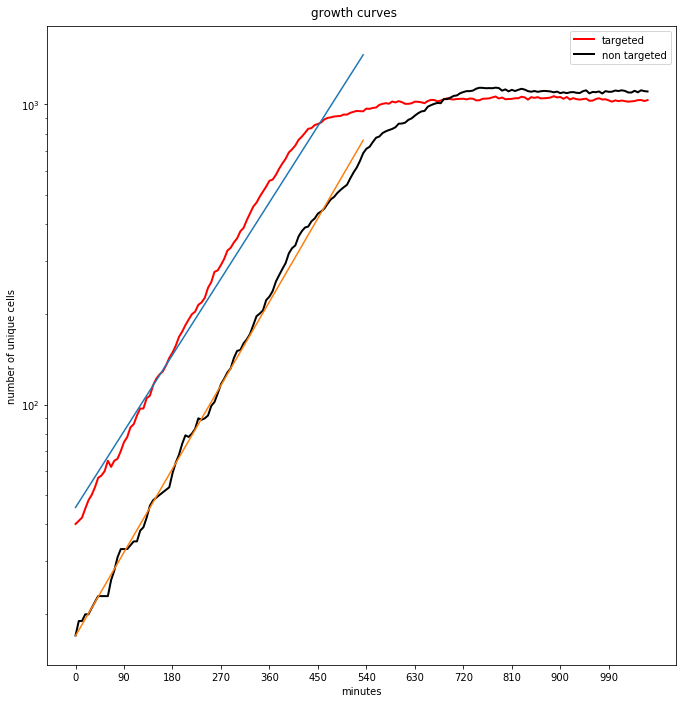

In [10]:
target = []
non = []

for i in range(track_csvs[1].frame.max()):
    target.append(len(track_csvs[1].loc[(track_csvs[1].y > 500) & (track_csvs[1].frame == i)].particle))
    non.append(len(track_csvs[1].loc[(track_csvs[1].y < 500) & (track_csvs[1].frame == i)].particle))

fig, ax = plt.subplots(1, 1, figsize=(10,10))
fig.tight_layout(pad=3.0)
fig.suptitle('growth curves')

ylab = 'number of unique cells'
xlab = 'minutes'

cutoff = 90
start = 0
times = np.arange(start,cutoff)*6

ax.set_yscale('log')
at.simpleline_plot(target, ax, '', 'red', 'targeted', ylab, xlab, multiplier=6)
at.simpleline_plot(non, ax, '', 'black', 'non targeted', ylab, xlab, multiplier=6)
p = np.polyfit(times, np.log(target[start:cutoff]),1)
ax.plot(times, np.exp(p[1])*np.exp(times*p[0]))
print('Growth rate target: {1} [1/min]'.format(i,p[0]))
p = np.polyfit(times, np.log(non[start:cutoff]),1)
ax.plot(times, np.exp(p[1])*np.exp(times*p[0]))
print('Growth rate non target: {1} [1/min]'.format(i,p[0]))